https://colab.research.google.com/drive/1lIu8VYQm7S7kE2_RBUy2tUxGXNgSSmer#scrollTo=DPtq-dZJHs1d

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile

In [2]:
zip_path = 'processed_lfw.zip' # Modifique este caminho se necessário
extract_path = 'processed_lfw'

# Cria o diretório de extração se não existir
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# Descompacta o arquivo
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset descompactado em: {extract_path}")

# Verifica o conteúdo (as 25 pastas de labels)
dataset_main_folder = os.path.join(extract_path, 'processed_lfw') # Ajuste se a pasta raiz dentro do zip for diferente
if not os.path.exists(dataset_main_folder):
    # Tenta encontrar a pasta principal se a estrutura do ZIP for diferente
    extracted_folders = [f for f in os.listdir(extract_path) if os.path.isdir(os.path.join(extract_path, f))]
    if len(extracted_folders) == 1: # Assume que há uma única pasta principal após a extração
        dataset_main_folder = os.path.join(extract_path, extracted_folders[0])
    else: # Se houver múltiplas pastas ou nenhuma, pode ser necessário ajustar manualmente
        print(f"Conteúdo extraído: {os.listdir(extract_path)}")
        print("Ajuste 'dataset_main_folder' para o caminho correto da pasta contendo as 25 subpastas de classes.")
        # Por exemplo, se as 25 pastas estão diretamente em '/content/dataset/processed_casiaweb'
        # dataset_main_folder = '/content/dataset/processed_casiaweb'

if os.path.exists(dataset_main_folder):
    print(f"Pasta principal do dataset encontrada: {dataset_main_folder}")
    print(f"Número de classes (pastas) encontradas: {len(os.listdir(dataset_main_folder))}")
else:
    print(f"ERRO: Pasta principal do dataset NÃO encontrada em {dataset_main_folder}. Verifique a estrutura do seu arquivo ZIP.")

Dataset descompactado em: processed_lfw
Pasta principal do dataset encontrada: processed_lfw/lfw_faces_extracted
Número de classes (pastas) encontradas: 34


In [3]:
# Parâmetros do dataset
IMG_HEIGHT = 112
IMG_WIDTH = 112
BATCH_SIZE_TRAIN = 32 # Batch size para treinamento
NUM_CLASSES = 34

# Carrega o dataset para treinamento e validação
# Use validation_split para dividir os dados
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_main_folder,
    labels='inferred',
    label_mode='categorical', # 'categorical' para one-hot encoding
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE_TRAIN,
    shuffle=True,
    seed=42,
    validation_split=0.2, # 20% para validação
    subset='training'
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_main_folder,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE_TRAIN, # Pode usar o mesmo batch size ou um diferente para validação
    shuffle=False, # Não precisa embaralhar o conjunto de validação
    seed=42,
    validation_split=0.2,
    subset='validation'
)

Found 2370 files belonging to 34 classes.
Using 1896 files for training.
Found 2370 files belonging to 34 classes.
Using 474 files for validation.


In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Carrega a base do VGG16 pré-treinada, sem as camadas de classificação (include_top=False)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Congela as camadas da base do VGG16 para não serem treinadas inicialmente
for layer in base_model.layers:
    layer.trainable = False

# Adiciona as novas camadas de classificação
x = base_model.output
x = GlobalAveragePooling2D()(x) # Camada de pooling global para reduzir dimensões
x = Dense(1024, activation='relu')(x) # Uma camada densa opcional
predictions = Dense(NUM_CLASSES, activation='softmax')(x) # Camada de saída com ativação softmax

# Cria o modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Exibe o resumo do modelo
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 112, 112, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 112, 112, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 7, 7, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 7, 7, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 7, 7, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 34)             │        34,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,274,850 (58.27 MB)

 Trainable params: 560,162 (2.14 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [5]:
model.compile(optimizer=Adam(learning_rate=0.0001), # Taxa de aprendizado menor para fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Epoch 1/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 183ms/step - accuracy: 0.0758 - loss: 10.6825 - val_accuracy: 0.0717 - val_loss: 5.9731
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.2725 - loss: 3.7540 - val_accuracy: 0.2004 - val_loss: 4.0483
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.4484 - loss: 2.3160 - val_accuracy: 0.3586 - val_loss: 2.8173
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.6072 - loss: 1.5457 - val_accuracy: 0.4937 - val_loss: 2.1009
Epoch 5/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.7141 - loss: 1.1040 - val_accuracy: 0.5823 - val_loss: 1.6410
Epoch 6/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.7838 - loss: 0.8016 - val_accuracy: 0.6414 - val_loss: 1.4048
Epoch 7/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.8448 - loss: 0.6430 - val_accuracy: 0.7131 - val_loss: 1.1270
Epoch 8/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.8773 - loss: 0.4879 - val_accuracy: 0.7532 

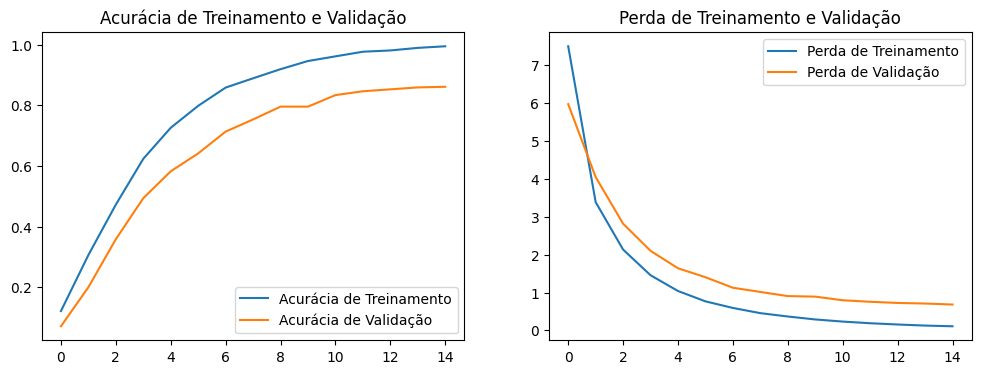

In [6]:
EPOCHS = 15 # Número de épocas. Ajuste conforme necessário.

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset
)

# Avalia o modelo (opcional, mas bom para verificar o desempenho final)
loss, accuracy = model.evaluate(validation_dataset)
print(f"\nPerda no conjunto de validação: {loss:.4f}")
print(f"Acurácia no conjunto de validação: {accuracy:.4f}")

# Plotar gráficos de acurácia e perda (opcional)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia de Treinamento')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de Treinamento e Validação')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perda de Treinamento')
plt.plot(epochs_range, val_loss, label='Perda de Validação')
plt.legend(loc='upper right')
plt.title('Perda de Treinamento e Validação')
plt.show()

In [8]:
class_names = sorted([d for d in os.listdir(dataset_main_folder) if os.path.isdir(os.path.join(dataset_main_folder, d))])
print(f"Número de classes: {len(class_names)}")
print(f"Classes: {class_names}")

Número de classes: 34
Classes: ['Alejandro_Toledo', 'Alvaro_Uribe', 'Andre_Agassi', 'Ariel_Sharon', 'Arnold_Schwarzenegger', 'Colin_Powell', 'David_Beckham', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Gloria_Macapagal_Arroyo', 'Guillermo_Coria', 'Hans_Blix', 'Hugo_Chavez', 'Jacques_Chirac', 'Jean_Chretien', 'Jennifer_Capriati', 'John_Ashcroft', 'John_Negroponte', 'Junichiro_Koizumi', 'Kofi_Annan', 'Laura_Bush', 'Lleyton_Hewitt', 'Luiz_Inacio_Lula_da_Silva', 'Megawati_Sukarnoputri', 'Nestor_Kirchner', 'Recep_Tayyip_Erdogan', 'Roh_Moo-hyun', 'Serena_Williams', 'Silvio_Berlusconi', 'Tom_Ridge', 'Tony_Blair', 'Vicente_Fox', 'Vladimir_Putin']


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


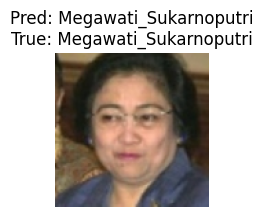

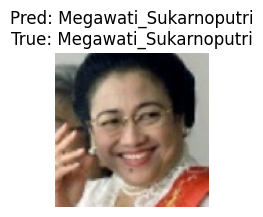

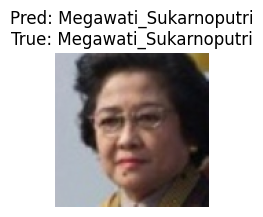

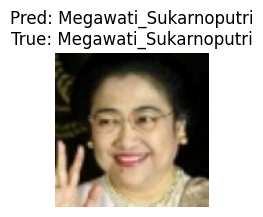

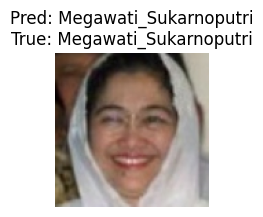

In [9]:
# Pega um lote de imagens do conjunto de validação para teste

for images, labels in validation_dataset.take(1):
    sample_images = images[:5] # Pega as primeiras 5 imagens do lote
    sample_labels = labels[:5]

    predictions = model.predict(sample_images)

    for i in range(len(sample_images)):
        predicted_class_index = np.argmax(predictions[i])
        predicted_class_name = class_names[predicted_class_index]
        true_class_index = np.argmax(sample_labels[i])
        true_class_name = class_names[true_class_index]

        plt.figure(figsize=(2,2))
        plt.imshow(sample_images[i].numpy().astype("uint8"))
        plt.title(f"Pred: {predicted_class_name}\nTrue: {true_class_name}")
        plt.axis("off")
        plt.show()

In [11]:
# 1. Salva o modelo Keras (opcional, mas bom para ter um backup)
keras_model_path = "vgg16_casia_face_model.keras"
model.save(keras_model_path)
print(f"Modelo Keras salvo em: {keras_model_path}")

# 2. Cria o TFLiteConverter
# Para garantir a forma de entrada (1, 112, 112, 3) e saída (1, 25)
# podemos criar um modelo concreto com essa especificação de entrada.
run_model = tf.function(lambda x: model(x))
# Precisa de uma entrada concreta para traçar o gráfico com a forma desejada
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(shape=[1, IMG_HEIGHT, IMG_WIDTH, 3], dtype=tf.float32)
)

# Agora converte usando a função concreta
converter = tf.lite.TFLiteConverter.from_concrete_functions(
    [concrete_func],
    trackable_obj=model # MODIFIED: Added trackable_obj
)

Modelo Keras salvo em: vgg16_casia_face_model.keras


In [12]:
# Especifica as otimizações para quantização (quantização de peso pós-treinamento é a mais simples)
# Para quantização inteira completa (full integer quantization), precisamos de um dataset representativo.
def representative_dataset_gen():
    for images, _ in train_dataset.take(100): # Usa 100 lotes do dataset de treinamento
        for i in range(images.shape[0]): # Itera sobre as imagens no lote
            # Pega uma única imagem e a normaliza se o modelo VGG16 espera isso
            # (VGG16 pré-processa internamente, mas para o dataset representativo é bom garantir o tipo float32)
            img = images[i]
            img = tf.cast(img, tf.float32) # / 255.0 se não foi feito antes
            yield [np.expand_dims(img, axis=0)] # Adiciona a dimensão do lote (batch_size=1)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
# Garante que o modelo convertido use apenas operações TFLite (para full integer)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS_INT8 # Para quantização int8
]
# Define os tipos de entrada e saída como int8 para quantização inteira
converter.inference_input_type = tf.int8  # ou tf.uint8 dependendo da sua preferência
converter.inference_output_type = tf.int8 # ou tf.uint8

In [35]:
try:
    print("Attempting full integer quantization (INT8)...")
    tflite_model_quantized = converter.convert()
    print("Full integer quantization successful.")
    tflite_model_path = "vgg16_lfw_quantized_int8.tflite" # Define path for successful int8
except Exception as e:
    print(f"Full integer quantization failed: {e}")
    print("Falling back to dynamic range quantization (float fallback)...")
    # For dynamic range, we don't need representative_dataset or int8 input/output types
    # Create a NEW converter directly from the Keras model
    converter_dynamic = tf.lite.TFLiteConverter.from_keras_model(model) # Use from_keras_model
    # MODIFIED: Enable resource variables for dynamic range fallback
    # This is usually handled by from_keras_model, but explicit setting doesn't hurt.
    # converter_dynamic.experimental_enable_resource_variables = True # Can remove if from_keras_model handles it
    converter_dynamic.optimizations = [tf.lite.Optimize.DEFAULT] # This will do dynamic range by default
    tflite_model_quantized = converter_dynamic.convert()
    tflite_model_path = "vgg16_lfw_quantized_dynamic.tflite" # Define path for dynamic range
    print("Dynamic range quantization successful.")

Attempting full integer quantization (INT8)...
Full integer quantization failed: 'NoneType' object has no attribute 'node'
Falling back to dynamic range quantization (float fallback)...
Saved artifact at '/tmp/tmpvdbnwsa8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 112, 112, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 34), dtype=tf.float32, name=None)
Captures:
  132227134547024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132227126111184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132227126109456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132227126109072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132227126112720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132227126111760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132227126112144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132227126112528: TensorSpec(shape=(),

In [36]:
if tflite_model_quantized:
    with open(tflite_model_path, 'wb') as f:
        f.write(tflite_model_quantized)
    print(f"TFLite model saved to: {tflite_model_path}")
    print(f"Size of TFLite model: {os.path.getsize(tflite_model_path) / 1024:.2f} KB")
else:
    print("TFLite conversion failed.")
    raise SystemExit("TFLite conversion failed.")

TFLite model saved to: vgg16_lfw_quantized_dynamic.tflite
Size of TFLite model: 15003.55 KB


In [38]:
# --- 7. Verify and Test the TFLite Model ---
print("Verifying TFLite model...")
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("\n--- TFLite Model Input Details ---")
print(f"Name: {input_details[0]['name']}")
print(f"Shape: {input_details[0]['shape']}") # Expected: [1, 112, 112, 3]
print(f"Type: {input_details[0]['dtype']}")   # Expected: int8 if full int quantization worked

print("\n--- TFLite Model Output Details ---")
print(f"Name: {output_details[0]['name']}")
print(f"Shape: {output_details[0]['shape']}") # Expected: [1, 25]
print(f"Type: {output_details[0]['dtype']}")  # Expected: int8 if full int quantization worked

Verifying TFLite model...

--- TFLite Model Input Details ---
Name: serving_default_keras_tensor:0
Shape: [  1 112 112   3]
Type: <class 'numpy.float32'>

--- TFLite Model Output Details ---
Name: StatefulPartitionedCall_1:0
Shape: [ 1 34]
Type: <class 'numpy.float32'>


In [39]:
# Check shapes
expected_input_shape = np.array([1, IMG_HEIGHT, IMG_WIDTH, 3])
expected_output_shape = np.array([1, NUM_CLASSES])

if np.array_equal(input_details[0]['shape'], expected_input_shape):
    print("Input shape is CORRECT.")
else:
    print(f"Input shape is INCORRECT. Expected {expected_input_shape}, Got {input_details[0]['shape']}")

if np.array_equal(output_details[0]['shape'], expected_output_shape):
    print("Output shape is CORRECT.")
else:
    print(f"Output shape is INCORRECT. Expected {expected_output_shape}, Got {output_details[0]['shape']}")

Input shape is CORRECT.
Output shape is CORRECT.



Testing TFLite model inference...
TFLite Prediction: Megawati_Sukarnoputri (True: Megawati_Sukarnoputri)


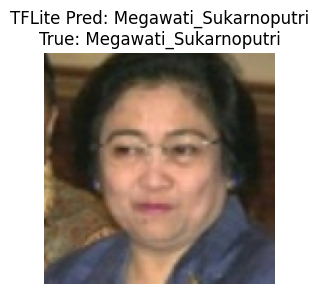

In [40]:
# Test inference with TFLite model
print("\nTesting TFLite model inference...")
# Get a sample image (make sure it's a single image with batch dim 1)
for test_images, test_labels in validation_dataset.unbatch().batch(1).take(1):
    sample_image_for_tflite = test_images # Already (1, H, W, C) and float32 [0,255]
    true_label_for_tflite_idx = np.argmax(test_labels[0])

    # Prepare input for TFLite model
    # If model is int8 quantized, input needs to be int8
    if input_details[0]['dtype'] == np.int8:
        input_scale, input_zero_point = input_details[0]['quantization']
        # Quantize the float32 input to int8
        input_data = (sample_image_for_tflite / input_scale) + input_zero_point
        input_data = tf.cast(input_data, dtype=tf.int8)
    elif input_details[0]['dtype'] == np.float32: # Dynamic range quantization might keep float32 input
        input_data = tf.cast(sample_image_for_tflite, dtype=tf.float32)
    else:
        print(f"Unsupported TFLite input dtype: {input_details[0]['dtype']}")
        break

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data_tflite = interpreter.get_tensor(output_details[0]['index'])

    # If output is int8, dequantize it to get meaningful probabilities/logits
    if output_details[0]['dtype'] == np.int8:
        output_scale, output_zero_point = output_details[0]['quantization']
        output_data_tflite_dequantized = (output_data_tflite.astype(np.float32) - output_zero_point) * output_scale
    else: # If output is float32
        output_data_tflite_dequantized = output_data_tflite

    predicted_tflite_class_idx = np.argmax(output_data_tflite_dequantized[0])
    predicted_tflite_label = class_names[predicted_tflite_class_idx]
    true_tflite_label = class_names[true_label_for_tflite_idx]

    print(f"TFLite Prediction: {predicted_tflite_label} (True: {true_tflite_label})")

    plt.figure(figsize=(3,3))
    # Display the original image (before any TFLite specific quantization for input)
    plt.imshow(sample_image_for_tflite[0].numpy().astype("uint8"))
    plt.title(f"TFLite Pred: {predicted_tflite_label}\nTrue: {true_tflite_label}")
    plt.axis("off")
    plt.show()
    break # Only test one image